# Simple Gaussian Processes with Numpy

Based on https://blog.dominodatalab.com/fitting-gaussian-process-models-python/

In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from IPython.display import display
import ipywidgets as widgets
%matplotlib inline

## The covariance function

A GP needs a mean function and a covariance function. For the mean, we'll just use 0. <br/>
For the covariance, we'll use a squared exponential.

$$\begin{aligned} \mu(u) &=0 \\ k(u,v) &= \theta_1\exp\left(-\frac{\theta_2}{2}(u - v)^2\right) \end{aligned}$$

In [2]:
def exponential_cov(u, v, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(u, v)**2)

Here is what the squared exponential looks like for a couple of values.

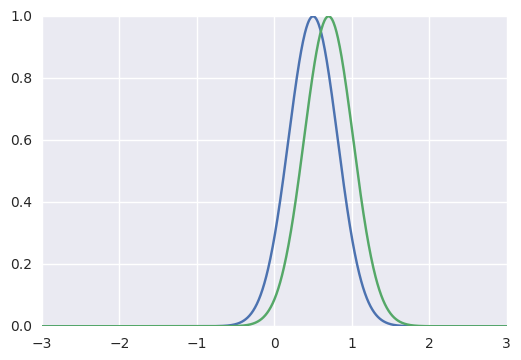

In [3]:
x_pred = np.linspace(-3, 3, 1000)
I = [1, 10]
plt.plot(x_pred, exponential_cov(0.5, x_pred, I))
plt.plot(x_pred, exponential_cov(0.7, x_pred, I))

## Conditioning distributions

We can use the covariance to find the probability distribution of one point conditional on another.

$$p(u \mid v) = \mathcal{N}(\mu_u + \Sigma_{uv}\Sigma_v^{-1}(y_v-\mu_v), \Sigma_u-\Sigma_{uv}\Sigma_v^{-1}\Sigma_{uv}^T)$$

In [4]:
def conditional(u, v, y_v, params=[1, 10]):
    cov_u = exponential_cov(u, u, params) # = 1 if u is a scalar
    cov_v = exponential_cov(v, v, params) # = 1 if v is a scalar
    cov_uv = exponential_cov(u, v, params)
    
    cov_v_inv = np.linalg.inv(cov_v)
    cov_T_uv = exponential_cov(v, u, params)
    
    mu = cov_uv.dot(cov_v_inv).dot(y_v)
    sigma = cov_u - cov_uv.dot(cov_v_inv).dot(cov_T_uv)

    return(mu.squeeze(), sigma.squeeze())

This function takes in some known points, v, along with their values, y_v. The u parameter is the points we would like predictions for.

NB: Don't get confused by the word covariance - we are not finding the covariance between two series. We are _assuming_ a covariance function and using it to constrain the new values.

Let's look in more details at a couple of examples. We calculate $\mu$ by multiplying the known $y$ values, $y_v$, by some matrix $\Sigma_{uv}\Sigma_v^{-1}$. Let's see what happens to this matrix as we change the input values, keeping the known points fixed.

In [5]:
def get_multiplier(u):
    v = [-0.6, 0.0, 0.2] # This is the points we already know
    y_v = [0.9, 0.8, 0.9]
    I = [1, 10]

    cov_u = exponential_cov(u, u, I)
    cov_v = exponential_cov(v, v, I)
    cov_uv = exponential_cov(u, v, I)
    cov_v_inv = np.linalg.inv(cov_v)
    return cov_uv.dot(cov_v_inv)

def show_multiplier(u):    
    f = plt.figure(figsize=(2,2))
    plt.matshow(get_multiplier(u), False)

First, what happens if we ask for the values of the points we already know?

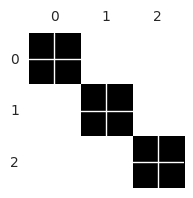

In [6]:
show_multiplier([-0.6, 0.0, 0.2])

Here the matrix $\Sigma_{uv}\Sigma_v^{-1}$ is just the identity matrix. This makes sense; since $u=v$, we know $\Sigma_{uv} = \Sigma_{v}$. 

Therefore $\Sigma_{uv}\Sigma_v^{-1}.v = v$. That is, asking about points we already know gives the right answer.

What if we slightly change one of the values in $u$?

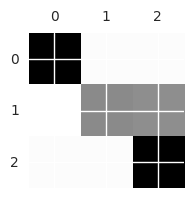

In [7]:
show_multiplier([-0.6, 0.1, 0.2])

Since we asked for a different middle value the middle row of $\Sigma_{uv}\Sigma_v^{-1}$ has changed, as has the predicted value.

The way it has changed is instructive. Remember that our known points are 
$$v = \begin{pmatrix}-0.6 & 0.0 & 0.2\end{pmatrix}$$
When our second requested point was 0.0, all the middle row's weight was concentrated in the center column. When we change it to 0.1, the weight is split evenly between the second and third columns. Intuitively, this is because 0.1 is half-way between 0.0 and 0.2, so the prediction carries equal weight from each of these.

Of course, we can change the order of the rows by asking for the points in a different order.

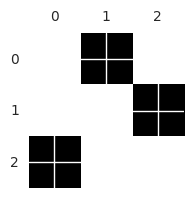

In [8]:
show_multiplier([0.0, 0.2, -0.6])

Here's an interactive version. Try changing the input values and see how it alters the matrix.

:Layout
   .DynamicMap.I  :DynamicMap   [u1,u2,u3]
   .Raster.I      :Raster   [x,y]   (z)
   .DynamicMap.II :DynamicMap   [u1,u2,u3]
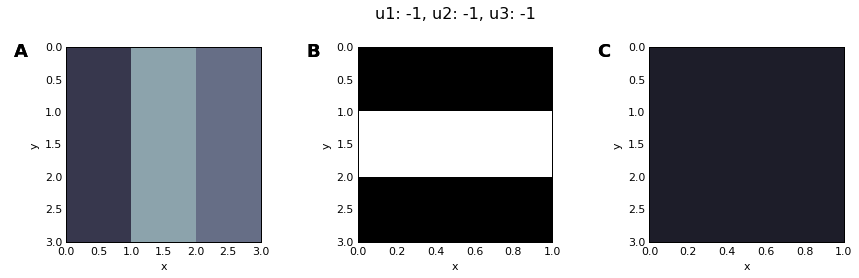

In [9]:
import holoviews as hv
hv.notebook_extension()
%opts Raster style(cmap='bone_r')

draw_matrix = lambda u1, u2, u3: hv.Raster(get_multiplier([u1, u2, u3]))

def draw_vector(u1, u2, u3):
    y_v = [0.9, -0.8, 0.9]
    mul = get_multiplier([u1, u2, u3])
    res = mul.dot(y_v)
    return hv.Raster(res.reshape(res.shape[0], 1))

u1_dim = hv.Dimension('u1', range=(-1.0, 1.0))
u2_dim = hv.Dimension('u2', range=(-1.0, 1.0))
u3_dim = hv.Dimension('u3', range=(-1.0, 1.0))

matrices = hv.DynamicMap(draw_matrix, kdims=[u1_dim, u2_dim, u3_dim])
vectors = hv.DynamicMap(draw_vector, kdims=[u1_dim, u2_dim, u3_dim])
matrices + hv.Raster(np.array([[0.9, -0.8, 0.9]]).T) + vectors

You'll notice that moving one slider can change the colour of all the rows, making them more grey, although it doesn't change their overall shape. This is probably due to rounding errors in the matrix inversion step, but I'm not quite sure.

## An Example

In [9]:
v = [0.5, -0.7, 2.0]
y_v = [0.9, -0.3, -2.5]

xpts = np.arange(-3, 3, step=0.01)
conds = [conditional(x, v, y_v) for x in xpts]

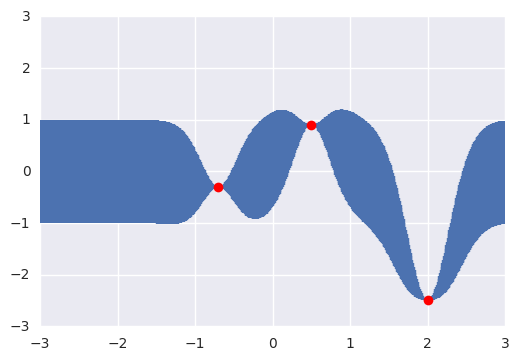

In [10]:
plt.errorbar(xpts, [c[0] for c in conds], yerr=[c[1] for c in conds], capsize=0)
plt.ylim(-3, 3)

for i, _ in enumerate(v):
    plt.plot(v[i], y_v[i], "ro")